<a href="https://colab.research.google.com/github/123gamal/Water_Flood_prediction_Satalite_images_image_segmentation/blob/main/image_segmentaion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Total matched pairs: 306
Image shape: (128, 128, 12)
Mask shape: (128, 128, 1)


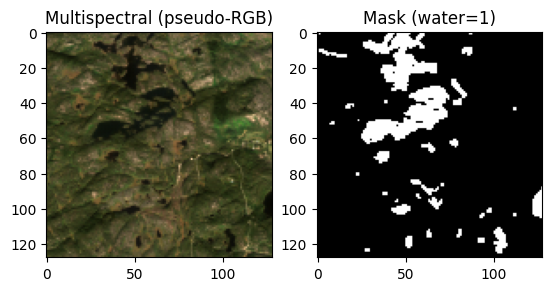

In [2]:
import os
import numpy as np
import tifffile as tiff
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

# ========================
# 1. Mount Google Drive
# ========================
from google.colab import drive
drive.mount('/content/drive')

# Path to dataset
BASE_DIR = "/content/drive/MyDrive/data-20250917T185435Z-1-001/data"
IMAGE_DIR = os.path.join(BASE_DIR, "images")
MASK_DIR = os.path.join(BASE_DIR, "labels")

# ========================
# 2. Loader functions
# ========================
def load_image(path):
    img = tiff.imread(path)  # shape (128,128,12)
    img = img.astype(np.float32)
    img = img / np.max(img)  # normalize to [0,1]
    return img

def load_mask(path):
    mask = np.array(Image.open(path))
    mask = (mask > 0).astype(np.uint8)  # ensure binary
    return mask[..., np.newaxis]  # shape (128,128,1)

# ========================
# 3. Match images & masks
# ========================
image_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith(".tif")])
mask_files  = sorted(os.listdir(MASK_DIR))

image_paths, mask_paths = [], []
for img_name in image_files:
    base_name = os.path.splitext(img_name)[0]
    for ext in [".png", ".jpg", ".tif"]:
        mask_name = base_name + ext
        if mask_name in mask_files:
            image_paths.append(os.path.join(IMAGE_DIR, img_name))
            mask_paths.append(os.path.join(MASK_DIR, mask_name))
            break

print(f"✅ Total matched pairs: {len(image_paths)}")

# ========================
# 4. Dataset class
# ========================
class SegmentationDataset(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=16):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.image_paths[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_y = self.mask_paths[idx*self.batch_size:(idx+1)*self.batch_size]

        X, Y = [], []
        for img_path, mask_path in zip(batch_x, batch_y):
            img = load_image(img_path)
            mask = load_mask(mask_path)
            X.append(img)
            Y.append(mask)

        return np.array(X), np.array(Y)

# ========================
# 5. Test & Visualize
# ========================
dataset = SegmentationDataset(image_paths, mask_paths, batch_size=1)

X, Y = dataset[0]
print("Image shape:", X[0].shape)  # (128,128,12)
print("Mask shape:", Y[0].shape)   # (128,128,1)

# Show pseudo-RGB + mask
rgb_img = X[0][:, :, [3,2,1]]
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

plt.subplot(1,2,1)
plt.imshow(rgb_img)
plt.title("Multispectral (pseudo-RGB)")

plt.subplot(1,2,2)
plt.imshow(Y[0].squeeze(), cmap="gray")
plt.title("Mask (water=1)")
plt.show()


In [3]:
# ============================================
# STEP 2 — Train / Validation Split
# ============================================
# Match images and masks by filename (without extension)
image_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith(".tif")])
mask_files  = sorted([f for f in os.listdir(MASK_DIR)])

# Build pairs only if both image and mask exist
image_paths, mask_paths = [], []
for img_name in image_files:
    base_name = os.path.splitext(img_name)[0]  # e.g., "0001"
    # Find mask with same name (any extension)
    for ext in [".png", ".jpg", ".tif"]:
        mask_name = base_name + ext
        if mask_name in mask_files:
            image_paths.append(os.path.join(IMAGE_DIR, img_name))
            mask_paths.append(os.path.join(MASK_DIR, mask_name))
            break

print(f"Total matched pairs: {len(image_paths)}")

# Now safe to split
from sklearn.model_selection import train_test_split
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

train_dataset = SegmentationDataset(train_imgs, train_masks, batch_size=16)
val_dataset   = SegmentationDataset(val_imgs, val_masks, batch_size=16)
# ============================================
# STEP 3 — U-Net Model
# ============================================
from tensorflow.keras import layers, models

def unet_model(input_shape=(128,128,12)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.UpSampling2D((2,2))(c4)
    u5 = layers.Concatenate()([u5, c3])
    c5 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c5)

    u6 = layers.UpSampling2D((2,2))(c5)
    u6 = layers.Concatenate()([u6, c2])
    c6 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D((2,2))(c6)
    u7 = layers.Concatenate()([u7, c1])
    c7 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c7)

    return models.Model(inputs, outputs)

model = unet_model()

Total matched pairs: 306


In [5]:
# ============================================
# STEP 4 — Compile Model
# ============================================
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)   # cast masks to float
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # threshold and cast
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', iou_metric, tf.keras.metrics.MeanIoU(num_classes=2)]
)


model.summary()

# ============================================
# STEP 5 — Train
# ============================================
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      3,488 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 64, 64,    │          0 │ conv2d_9[0][0]  

 Total params: 1,949,473 (7.44 MB)

 Trainable params: 1,949,473 (7.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 249s 14s/step - accuracy: 0.7423 - iou_metric: 0.0680 - loss: 0.8554 - mean_io_u: 0.3616 - val_accuracy: 0.8907 - val_iou_metric: 0.5244 - val_loss: 0.5387 - val_mean_io_u: 0.3878
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.8791 - iou_metric: 0.5291 - loss: 0.4439 - mean_io_u: 0.3836 - val_accuracy: 0.9059 - val_iou_metric: 0.5952 - val_loss: 0.2840 - val_mean_io_u: 0.3878
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.8993 - iou_metric: 0.6079 - loss: 0.2867 - mean_io_u: 0.4048 - val_accuracy: 0.9087 - val_iou_metric: 0.6122 - val_loss: 0.2633 - val_mean_io_u: 0.3878
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.9046 - iou_metric: 0.6671 - loss: 0.2775 - mean_io_u: 0.3911 - val_accuracy: 0.9066 - val_iou_metric: 0.6142 - val_loss: 0.2326 - val_mean_io_u: 0.3878
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.8971 - iou_metric: 0.6355 - loss: 0.2817 - mean_io_u: 0.3928 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


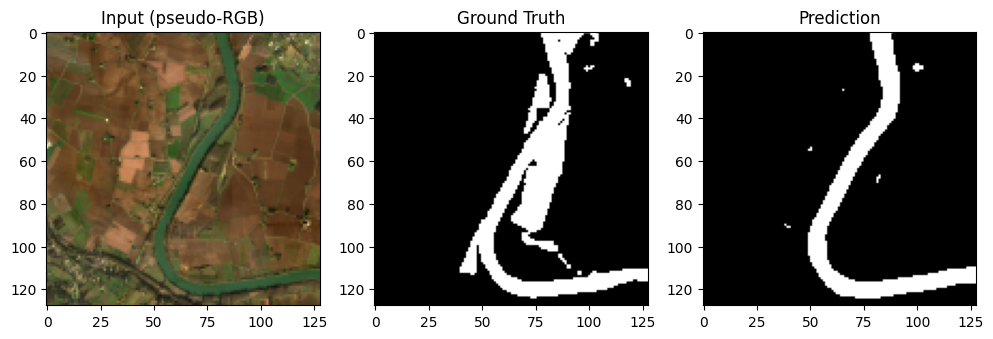

In [6]:
# ============================================
# STEP 6 — Evaluate & Visualize Predictions
# ============================================
X_val, Y_val = val_dataset[0]  # first batch
preds = model.predict(X_val)

# Plot first example
rgb_img = X_val[0][:,:, [3,2,1]]
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(rgb_img)
plt.title("Input (pseudo-RGB)")

plt.subplot(1,3,2)
plt.imshow(Y_val[0].squeeze(), cmap="gray")
plt.title("Ground Truth")

plt.subplot(1,3,3)
plt.imshow(preds[0].squeeze()>0.5, cmap="gray")
plt.title("Prediction")
plt.show()

In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

def test_model(model, image_path, mask_path=None, bands=[3,2,1], threshold=0.5):
    """
    Test the trained U-Net model on a single image.

    Args:
        model       : trained Keras model
        image_path  : path to the input .tif image
        mask_path   : optional, path to ground truth mask (for evaluation)
        bands       : which bands to show as pseudo-RGB
        threshold   : threshold for binary mask (default=0.5)
    """
    # Load input image
    img = load_image(image_path)  # shape (128,128,12)
    X = np.expand_dims(img, axis=0)  # add batch dim

    # Predict
    pred = model.predict(X)[0]  # shape (128,128,1)
    pred_mask = (pred > threshold).astype(np.uint8).squeeze()

    # Build visualization
    rgb_img = img[:,:,bands]
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(rgb_img)
    plt.title("Input (pseudo-RGB)")

    if mask_path:
        gt_mask = load_mask(mask_path).squeeze()
        plt.subplot(1,3,2)
        plt.imshow(gt_mask, cmap="gray")
        plt.title("Ground Truth")

        # Compute IoU
        y_true = tf.cast(gt_mask, tf.float32)
        y_pred = tf.cast(pred_mask, tf.float32)
        intersection = tf.reduce_sum(y_true * y_pred)
        union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
        iou = (intersection + 1e-6) / (union + 1e-6)
        print(f"IoU score: {iou.numpy():.4f}")
    else:
        plt.subplot(1,3,2)
        plt.imshow(pred_mask, cmap="gray")
        plt.title("Prediction Only")

    # Always show prediction
    plt.subplot(1,3,3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Prediction")
    plt.show()

    return pred_mask


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


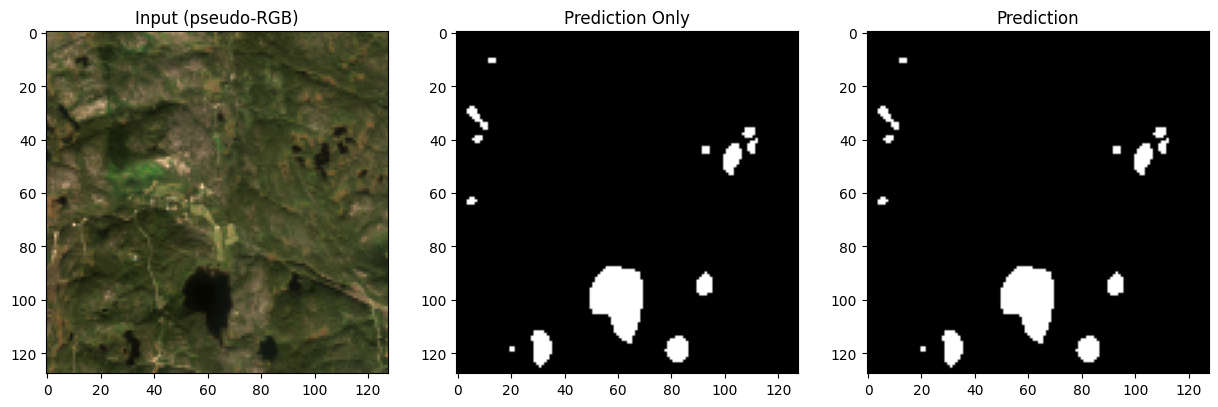

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
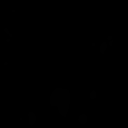

In [15]:
test_model(model=model, image_path="/content/drive/MyDrive/data-20250917T185435Z-1-001/data/images/190.tif", mask_path=None, bands=[3,2,1], threshold=0.5)

In [17]:
model.save("water_segmentation_unet.h5")